<a href="https://colab.research.google.com/github/JanNogga/rl_ss24/blob/main/RL_Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Robot Learning

### Assignment 11

**Points on this assignment sheet are considered bonus points. They do not increase the threshhold required for exam admittance and count towards your total score.**

Solutions are due 09.07.2024 before the lecture.

As usual, only uncomment and run the cell below if you are using this notebook in a colab environment!

In [1]:
!apt-get -qq install xvfb x11-utils &> /dev/null
!pip install ufal.pybox2d --quiet &> /dev/null
!pip install pyvirtualdisplay moviepy pyglet PyOpenGL-accelerate --quiet &> /dev/null

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import random

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [3]:
# set up showing animations from the environment in Colab.
Display(visible=False).start()

## Task 11.1)

Familiarize yourself with the prediction of continuous function values using supervised learning by examining the example below, in which a toy dataset containing samples $(x, y=f(x))$ is used to fit a fully connected neural network to the polynomial $f$.

In [4]:
## define the toy dataset
class ToyPolynomialDataset(Dataset):
    def __init__(self, samples, A, B, C):
        self.samples = samples
        self.targets = A*torch.pow(self.samples, 2) + B*self.samples+ C

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        return torch.atleast_1d(self.samples[idx]), torch.atleast_1d(self.targets[idx])

## characterize the polynomial f
A, B, C = 5, 3, -2
## discretize sampling interval of f
samples = torch.linspace(-10, 10, steps=64)
## split into training and validation data
indices = list(range(samples.shape[0]))
split = int(np.ceil(0.8 * samples.shape[0]))
np.random.shuffle(indices)
train_idx, valid_idx = indices[:split], indices[split:]
## create training and validation datasets
train_data = ToyPolynomialDataset(samples[train_idx], A, B, C)
valid_data = ToyPolynomialDataset(samples[valid_idx], A, B, C)
## create corresponding dataloaders, which handle batching and shuffling
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=False)

In [5]:
## define a model to approximate f
class Net(nn.Module):
    def __init__(self, input_dim=1, hidden_layer_dim=8, output_dim=1):
        super(Net, self).__init__()
        # Create some fully connected layers
        self.layers = [nn.Linear(input_dim, hidden_layer_dim, bias=True),
                       nn.LeakyReLU(),

                       nn.Linear(hidden_layer_dim, hidden_layer_dim, bias=True),
                       nn.LeakyReLU(),

                       nn.Linear(hidden_layer_dim, output_dim, bias=True)]
        # Combine these layers into a neural network
        self.net = nn.Sequential(*self.layers)

    def forward(self, s):
        # Convert input state to tensor if necessary
        # np_check does absolutely nothing here, but deals with open ai gym states
        np_check = type(s) is np.ndarray
        x = torch.from_numpy(s).float().view(1,-1).to(next(self.parameters()).device) if np_check else s
        # Map state to action vector
        x = self.net(x)
        # Return format of action based on input type
        return np.clip(x.squeeze().detach().cpu().numpy(),-1,1) if np_check else x

In [6]:
## check if there is a gpu available - if so, use it
# you can activate one at Edit→Notebook Settings, but don't need to
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)
# create an instance of your model
model = Net().to(device)
# define a criterion, setup optimizer and schedule to reduce learning rate
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-6)

Using device: cuda


In [7]:
## typical layout of a neural regression task:
# -> alternate validation and training epochs, track losses
N_EPOCHS = 2500

best_valid_loss = 1e25
losses_train, losses_valid = [], []
progress_bar = tqdm(range(N_EPOCHS), total=N_EPOCHS, position=0, leave=True)
for i in progress_bar:
    # validation epoch
    loss_valid = 0
    # important to set model to eval mode for some layers (like dropout)
    model.eval()
    # don't need gradients for validation
    with torch.no_grad():
        # dataloaders provide batches of training samples and targets
        for x_valid, y_valid in valid_loader:
            x_valid, y_valid = x_valid.to(device), y_valid.to(device)
            net_out_valid = model(x_valid)
            # loss between network output and target
            loss_valid += criterion(net_out_valid, y_valid)
    # keep track of losses
    losses_valid.append(loss_valid.item()/len(valid_data))
    # if the valid loss is best so far, save model
    if losses_valid[-1] < best_valid_loss:
        best_valid_loss = losses_valid[-1]
        torch.save(model.state_dict(), 'best_weights.pth')

    # training epoch
    loss_train_sum = 0
    # important to set model to train mode for some layers (like dropout)
    model.train()
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        net_out = model(x_train)
        loss_train = criterion(net_out, y_train)
        # this term keeps track of the loss
        loss_train_sum += loss_train.item()
        loss_train /= x_train.shape[0]
        # backprop error and update network weights
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    losses_train.append(loss_train_sum/len(train_data))
    learning_rates = np.array([g['lr'] for g in optimizer.param_groups])
    # Show current training stats
    episode_summary = [f"{i+1}:"] + [f'Train: {losses_train[-1]}, Valid: {losses_valid[-1]}, LR: {learning_rates.mean()}']
    # Set progress bar
    progress_bar.set_description("".join(episode_summary))
    # Decrease learning rate if necessary
    scheduler.step(losses_valid[-1])
# Optional - set model to the best encountered during training
model.load_state_dict(torch.load('best_weights.pth'))
model.eval()
print('Training completed!')

  0%|          | 0/2500 [00:00<?, ?it/s]

Training completed!


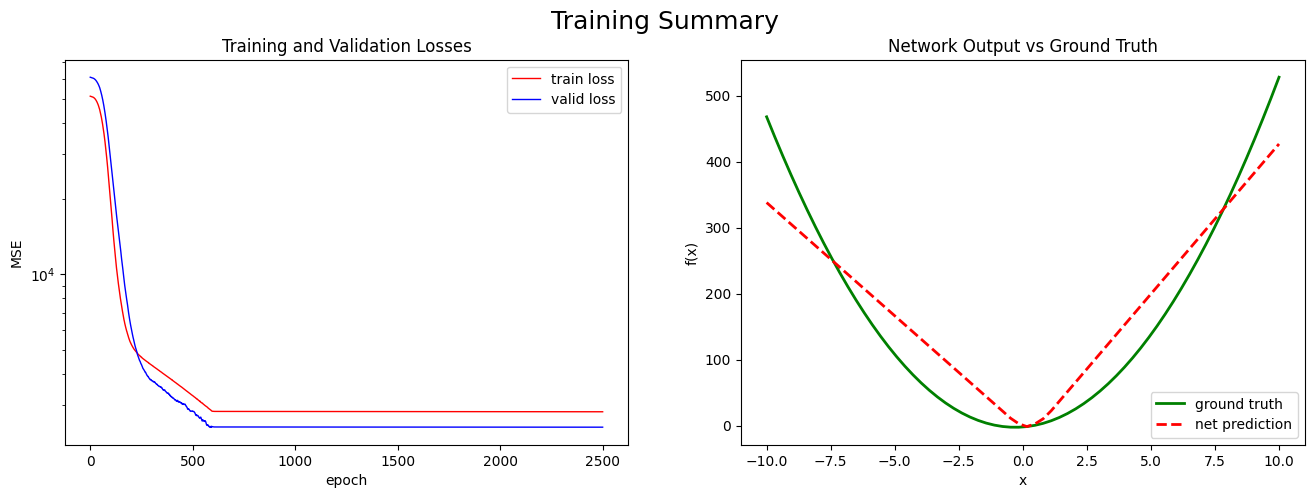

In [8]:
# Get ground truth and network prediction
gt = A*torch.pow(samples, 2) + B*samples + C
with torch.no_grad():
    net_out = model(samples.view(-1,1).to(device)).cpu().numpy()
# Finally plot the learning curves and the approximated function
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)
fig.suptitle('Training Summary', fontsize=18)
ax[0].plot(np.array(losses_train), label='train loss', c='r', lw=1)
ax[0].plot(np.array(losses_valid), label='valid loss', c='b', lw=1)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("MSE")
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('Training and Validation Losses')

ax[1].plot(samples, gt, label='ground truth', c='g', lw=2)
ax[1].plot(samples, net_out, label='net prediction', c='r', lw=2, ls='--')
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].legend(loc="lower right")
ax[1].set_title('Network Output vs Ground Truth')
plt.show()

Please answer the following questions on the neural regression task above:

* How many parameters are optimized in total?

* Which signs are there that the models needs more/less parameters/layers?

* Discuss whether the model has overfit the training data.

<div style="text-align: right; font-weight:bold"> 3 + 1 + 1 = 5 BONUS Points </div>

Please answer in this text cell.

## Task 11.2)

Suppose you are given a complicated RL environment with an $N$-dimensional state space and a $D$-dimensional continous action space as well as a human expert who can perform well in this environment using a joystick.

What data needs to be collected and what adjustments must be made to the procedure above to apply behavioral cloning? Answer as specifically as possible and also refer to the hyperparameters used in the training process seen in the previous task.

<div style="text-align: right; font-weight:bold"> 7 BONUS Points </div>

Please answer in this text cell.

## Task 11.3)

Familiarize yourself with the Gym environment [Bipedal Walker v3](https://gymnasium.farama.org/environments/box2d/bipedal_walker/) by examing the code below, which simulates and animates one episode using the random agent.

In [9]:
# Create the environment
env = gym.make('BipedalWalker-v3')
# Reset the environment
state = env.reset()
# Track whether the episode is over
done = False
# List to append the frames produced by the environment renderer
frames = []
while not done:
    # Render current situation and append to frames
    frames.append(env.render('rgb_array'))
    # Select a random action
    action = env.action_space.sample()
    # Execute this action
    state, reward, done, info = env.step(action)
# Print the number of frames
print('Number of frames:', len(frames))
# Prevent the renderer from showing artifacts
plt.close()

  and should_run_async(code)

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



Number of frames: 62


In [10]:
# Helper function to animate a list of frames as produced above
def visualize_trajectory(frames, fps=30):
  duration = int(len(frames) // fps + 1)
  fig, ax = plt.subplots()
  def make_frame(t, ind_max=len(frames)):
      ax.clear()
      ax.imshow(frames[min((int(fps*t),ind_max-1))])
      return mplfig_to_npimage(fig)
  plt.close()
  return VideoClip(make_frame, duration=duration)

In [11]:
# Get the animation from the frames of the played episode
animation = visualize_trajectory(frames)
# Show the animation
animation.ipython_display(fps=30, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Additionally, examine the cells below, which download and setup dataloaders for expert traces from 256 episodes for training and 24 episodes for validation. In this case the expert was simulated using a walking heuristic provided by Gym.

In [12]:
# download the data
!wget https://github.com/JanNogga/rl_ss24/raw/main/walker_heuristic_train.pt &> /dev/null
!wget https://github.com/JanNogga/rl_ss24/raw/main/walker_heuristic_valid.pt &> /dev/null
# define dataset
class HeuristicWalkerDataset(Dataset):
    def __init__(self, f):
        data = torch.load(f)
        self.states, self.actions = data['states'].float(), data['actions'].float()

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        # output is s, a --- ready for batching in dataloader
        return self.states[idx], self.actions[idx]

In [13]:
# create the datasets for training and validation
walker_train_data = HeuristicWalkerDataset(f='walker_heuristic_train.pt')
walker_valid_data = HeuristicWalkerDataset(f='walker_heuristic_valid.pt')

# create the corresponding dataloaders
walker_train_loader = DataLoader(walker_train_data, batch_size=256, shuffle=True)
walker_valid_loader = DataLoader(walker_valid_data, batch_size=1024, shuffle=False)

Use behavioral cloning to learn a policy for BipedalWalker-v3. Make sure to show your learning curve, and animate an episode of your agent walking. You can make use of the blueprint provided in task 10.1) but need to adapt hyperparameters and the model architecture.

Measured by average MSE with respect to the training data, your agent should score lower than $0.009$ as weak baseline. Without too much overfitting, your agent should start properly walking at an average training MSE of around $0.0015$. Training is possible in less than 20 minutes, but will be slightly faster if you activate the GPU capabilities of your colab session.

<div style="text-align: right; font-weight:bold"> 8 BONUS Points </div>

In [ ]:
# Your code can go here.